# Tutorial for anomaly detection with Matrix Profile

### Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from algorithms_matrix_profile import *
from utils import * 
import SynthData

### Selecting data
At first we need to select data. The time series X must be a numpy array of shape (d,n) where n is the length of the series and d the number of dimensions.

Here we have a time series where the anomalies do not occur on every dimensions. The anomaly times are in red.

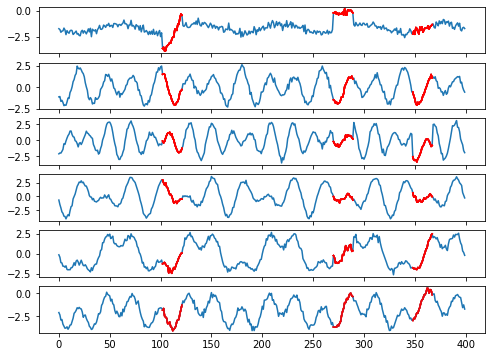

anomalies : [102 348 270]


In [2]:
rng = np.random.RandomState(42)
n_samples=400
data = SynthData.MultipleUnknownSig(nb_ano=3,nb_ano_series=3, nb_dim=6, where=-1, type_ano='contextual', n_samples=n_samples, 
                                    sigma_noise=0.2, ano_size=20, different_freq=False, rng = rng)
X = data.S

#plot the series 
plot_series(X, motifs_times = data.where, window_size=20) 
#we can plot only the series without the anomalies by removing the arguments 'motifs_times' and 'window_size'
print('anomalies :', data.where )

### Computing the matrix profile 

Univariate matrix profile is a new time series that gives for each time window of length $m$ of the original time series the the distance to the closest window that does not overlap. 

For multivariate time series the principle is the same but, we consider a fixed number $k$ of dimensions when computing the distance. For anomaly detection, we consider the dimensions for which the distance is maximal : 
$$d_{\max}^{(k)}(X[i:i+m-1], X[n:n+m-1]) = \max_{K \in \mathcal{M}, |K|=k} d(X_K[i:i+m-1], X_K[n:n+m-1]) $$
And the matrix profile is given by : 
$$ \operatorname{MP}_k[n]= \min\limits_{i>n+m \mbox{ or } i<n-m} d^{(k)}_{\max} (X[n:n+m-1],X[i:i+m-1]) = \min\limits_{i>n+m \mbox{ or } i<n-m} \max\limits_{K \in \mathcal{M}, |K|=k} d(X_K[i:i+m-1], X_K[n:n+m-1])$$

When computing multivarite matrix profile, we compute $\operatorname{MP}_k$ for all $k$. 

In [3]:
m=20  #choice of the window size for matrix profile
P, P_subspace, time = computeMatrixProfile(X, m=m, take_max=True) #computation of matrix profile
# the argument take_max is to keep the worse dimensions. Change to False for motif selection
# the default distance is standard euclidean distance. Possible to change to normalised euclidean distance 
        #by setting  'only_euc' to False 
    


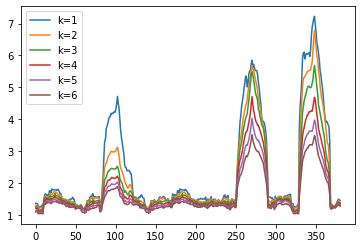

In [4]:
for i in range(6): 
    plt.plot(P[i], label="k="+str(i+1))
    plt.legend()

One can take the maximum of matrix profile for each dimension to detect the 'worse' anomaly and the dimensions used to find out this anomaly. 

1-dimensional motifs detection


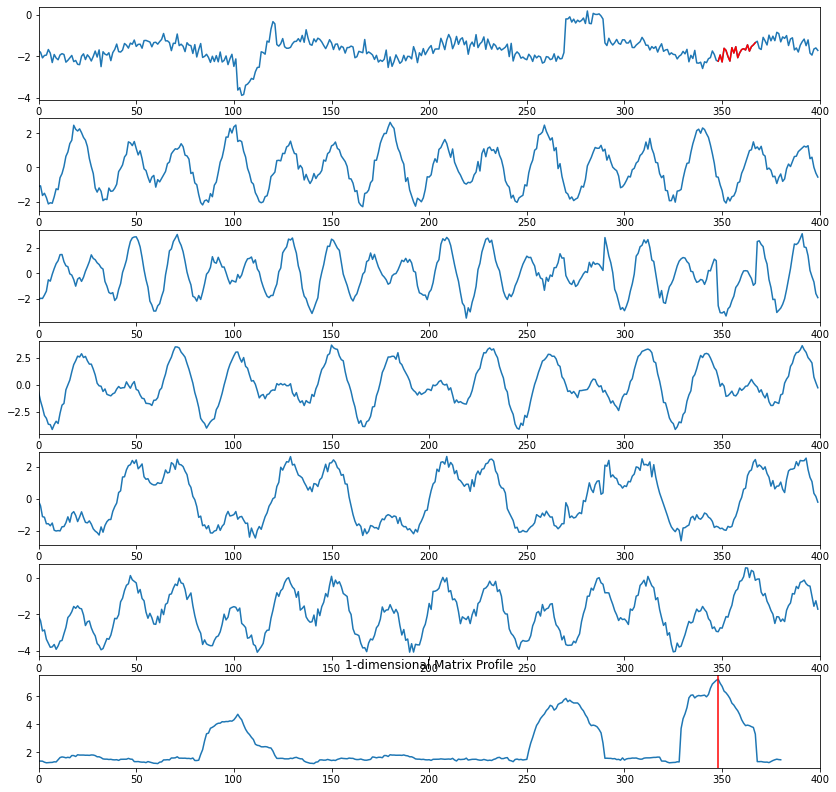

2-dimensional motifs detection


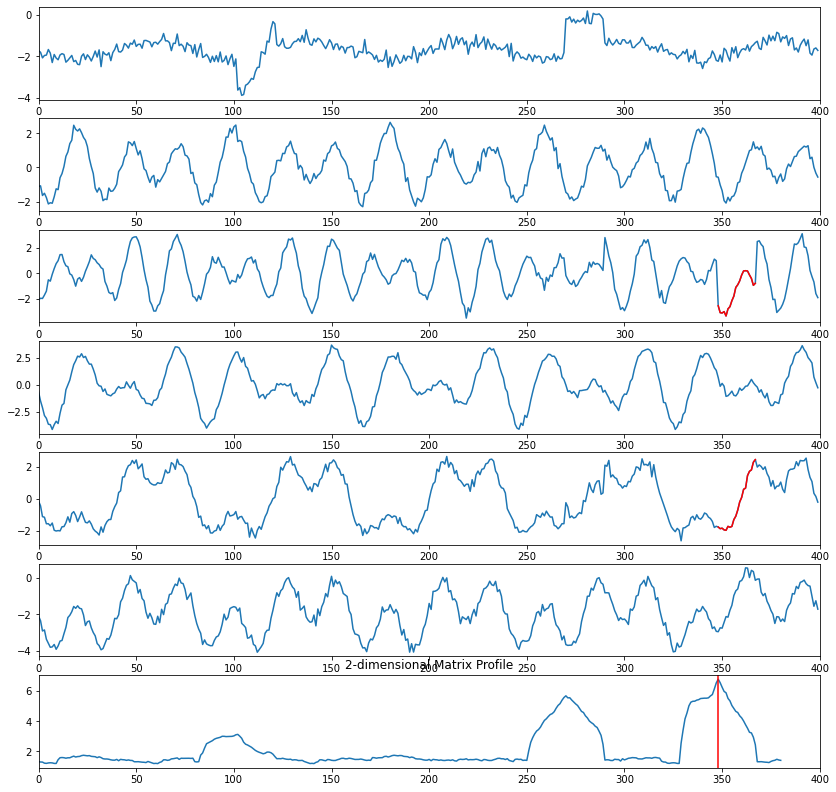

3-dimensional motifs detection


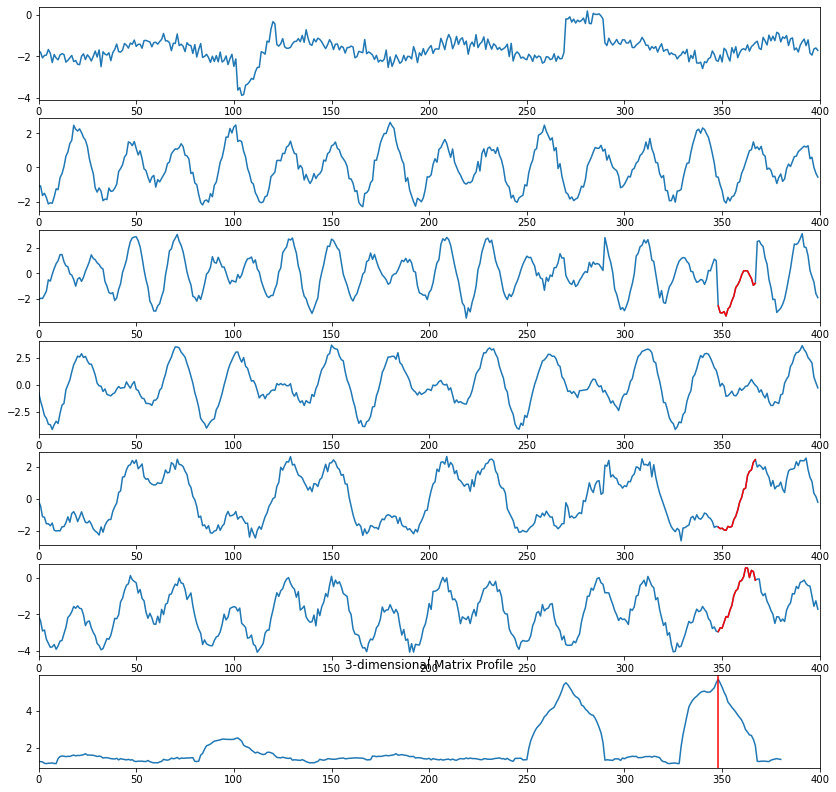

4-dimensional motifs detection


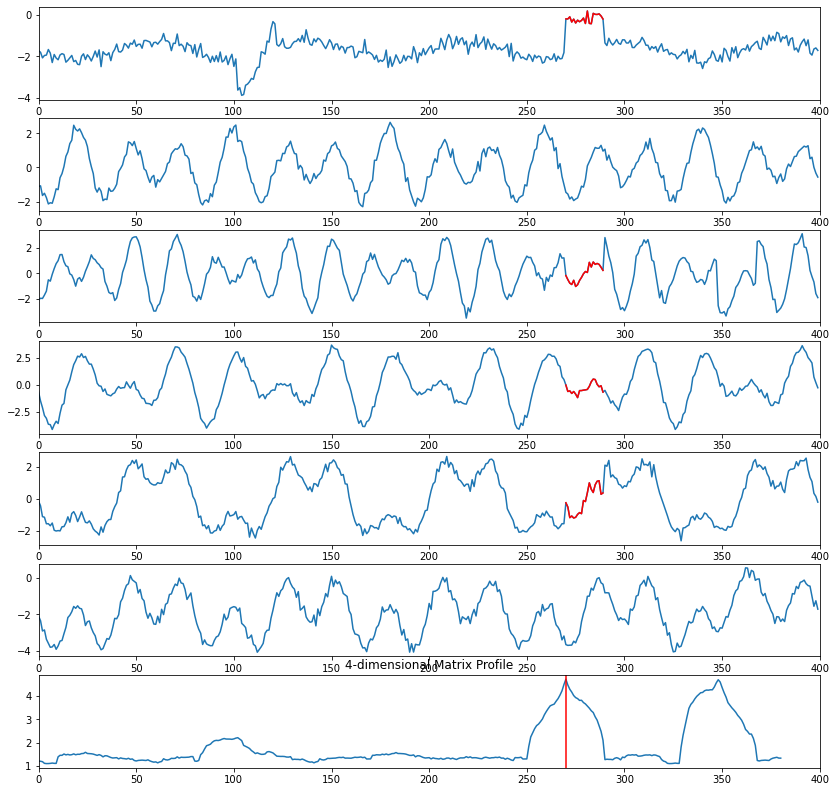

5-dimensional motifs detection


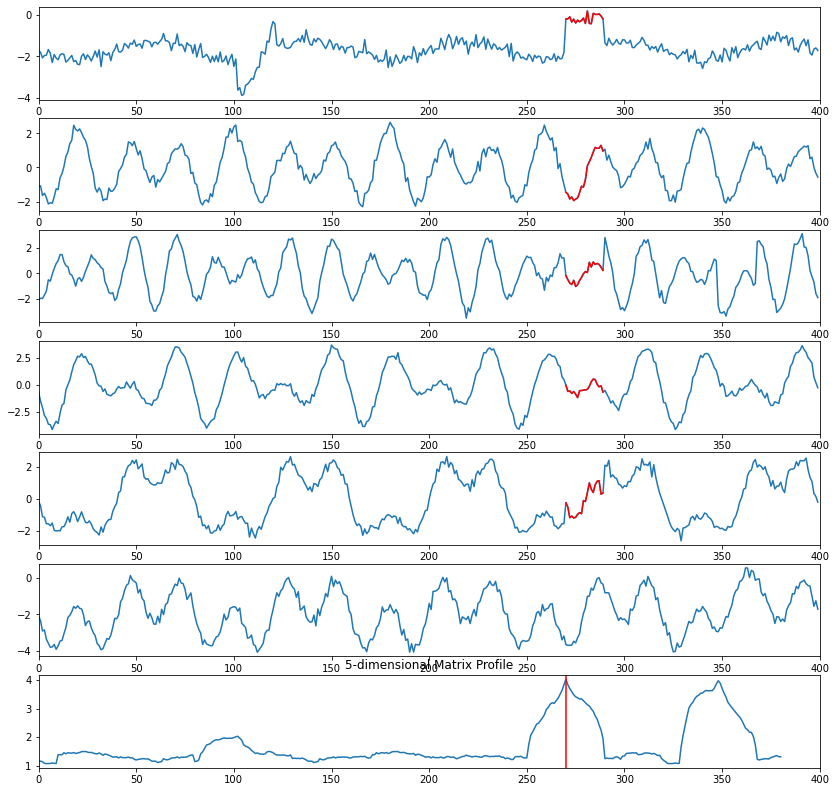

6-dimensional motifs detection


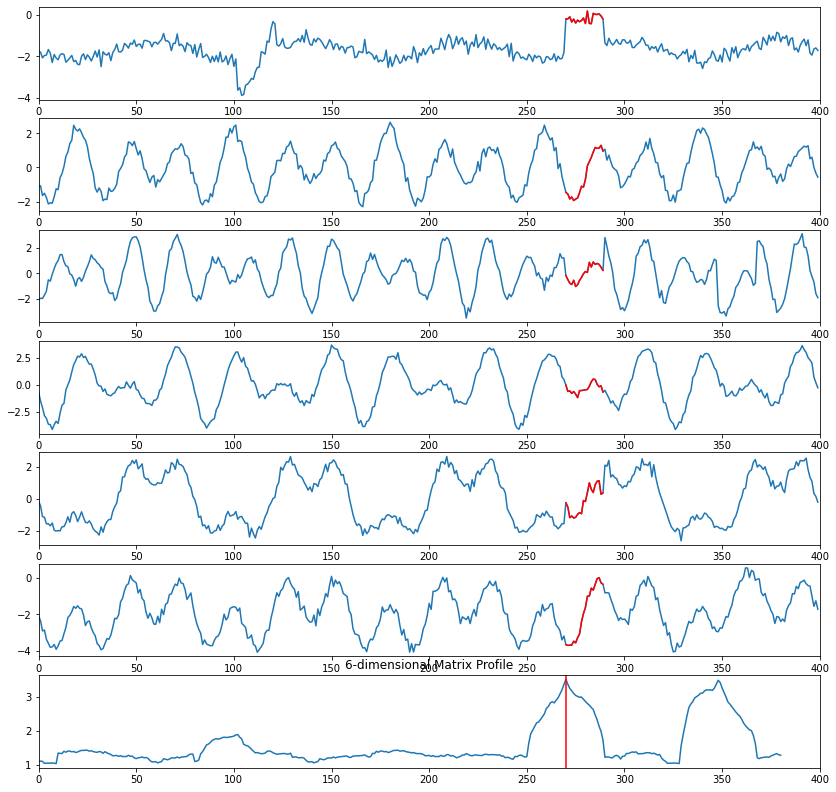

In [5]:
anomaly_time, anomaly_series = detect_anomaly(P, P_subspace)

plot_series_motifs(X,P,m,anomaly_time, anomaly_series)

### Detecting anomalies from matrix profile 

With multivariate matrix profile we still have as many dimensions as for the original time series. To keep relevant information, we perform a regression on the value of matrix profile depending on the number of dimensions and keep only the slope for each timestamp. 

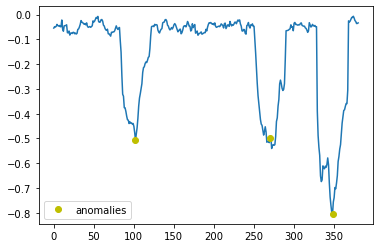

In [6]:
reg = regression_coef(P)
plt.plot(np.arange(P.shape[1]),reg)
plt.plot(data.where,reg[data.where],'yo', label='anomalies')
plt.legend() 

Now we can detect the anomalies 

In [9]:
ano = find_anomalies_from_mp(P, m, thresh=0.82)
print(ano)

[348 272 102]


Finally we plot the anomalies on the slope series and on the original signal

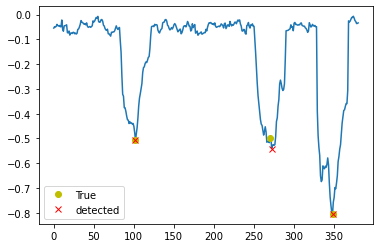

In [10]:
reg = regression_coef(P)
plt.plot(np.arange(P.shape[1]),reg)
plt.plot(data.where,reg[data.where],'yo', label='True')
plt.plot(ano,reg[ano],'rx', label='detected')
plt.legend()

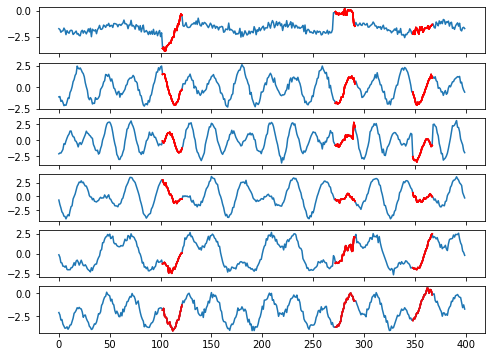

In [13]:
plot_series(X, motifs_times = ano, window_size= m)